<a href="https://colab.research.google.com/github/GubioGL/MachineLearning/blob/main/MLinregression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn import linear_model
from torch import nn

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import torch  as tc


# v= Constante

## ML-std

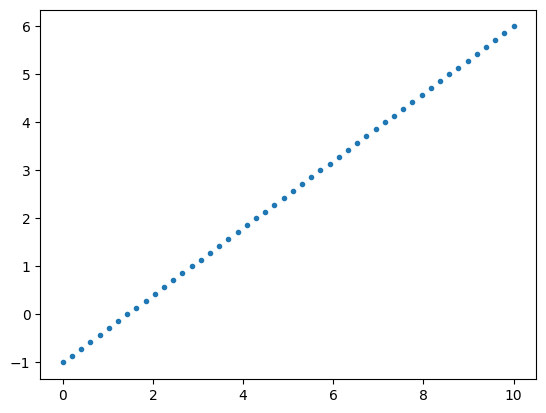

In [5]:
def eq_movimento(x_0,v_,t_):
    return  x_0 + v_*t_

t = np.linspace(0,10)
plt.plot(t,eq_movimento(x_0=-1,v_=0.7,t_=t),".")

plt.show()

Com o .LinearRegression() do sckitleanr podemos aprender os parâmetros(posição inicial e velocidade)

In [6]:
t = np.linspace(0,10).reshape((-1, 1))
y = eq_movimento(x_0=-1,v_=0.7,t_=t)

reg = linear_model.LinearRegression()
reg.fit(t,y)# FITANDO
print("a: ",reg.coef_)
print("b: ",reg.intercept_)


a:  [[0.7]]
b:  [-1.]


Com o DecisionTreeRegressor podemos aprender a função

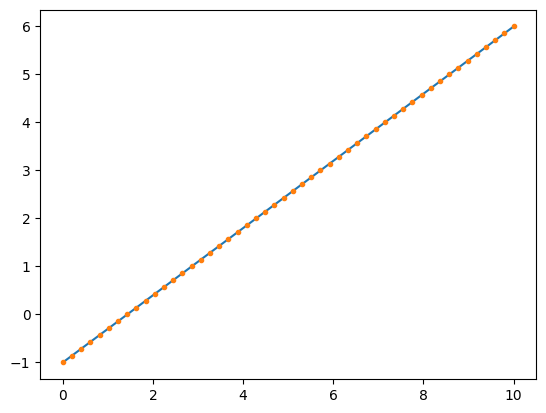

In [7]:
from sklearn.tree import DecisionTreeRegressor

RT = DecisionTreeRegressor(criterion = "squared_error")
RT.fit(t,y)# FITANDO

t_tes = np.linspace(0,10).reshape((-1, 1))
predição = RT.predict(t_tes)

plt.plot(t,y,"-")
plt.plot(t_tes,predição,".")

plt.show()

## ML-NN

In [8]:
class Regressao_0(nn.Module):
    def __init__(self,neuronio):
        super().__init__()
        self.layer_1 = nn.Linear(1,neuronio)
        self.layer_3 = nn.Linear(neuronio,1)
        self.A_layer = nn.ReLU()

    def forward(self, x):
        x = self.A_layer(self.layer_1(x))
        x = self.A_layer(self.layer_3(x))
        return x

class Regressao_1(nn.Module):
    def __init__(self,neuronio):
        super().__init__()
        self.layer_1 = nn.Linear(1,neuronio)
        self.layer_2 = nn.Linear(neuronio,neuronio)
        self.layer_3 = nn.Linear(neuronio,1)
        self.A_layer = nn.Tanh()

    def forward(self, x):
        x = self.A_layer(self.layer_1(x))
        x = self.A_layer(self.layer_2(x))
        x = self.layer_3(x)
        return x

In [9]:
class Loss_parametro(nn.Module):
    def __init__(self,inputs,targets):
        super(Loss_parametro, self).__init__()
        self.t = inputs
        self.x = targets
    def forward(self,outputs):
        # função 1° grau: x- x0 -vt = 0
        funcao_1_grau = self.x - self.x[0] - outputs*self.t
        loss_solution = tc.mean( abs(funcao_1_grau) )
        # podemos impor que independe do input o parametro deve ser igual
        v_medio = outputs.mean()
        loss_const = tc.mean((outputs - v_medio) ** 2)
        return loss_solution + loss_const

class Loss_edo(nn.Module):
    def __init__(self,rede_neural,ic,velocidade,inputs):
        super(Loss_edo, self).__init__()
        self.rede = rede_neural
        self.v = velocidade
        self.t = inputs
        self.x0 = ic
    def forward(self,y_pred):
        dydt = tc.autograd.grad(y_pred, self.t, grad_outputs=tc.ones_like(y_pred), create_graph=True)[0]
        # condição inicial x(0)
        loss_ic = (y_pred[0] - self.x0)**2
        # Derivada da função em relação a entrada
        # edo : dx/dt = v
        # estamos usando [1:] para escluir a condição inicial
        loss_edo = tc.mean( (dydt - self.v )**2 )

        return loss_ic + loss_edo

class Loss_edo2(nn.Module):
    """
    Nessa loss function vamos usar os dados experimentais para descobri qual é a
    edo , isso significa que vamos descobri os parâmetro da edo.
    """
    def __init__(self,inputs,data):
        super(Loss_edo2, self).__init__()
        #self.rede = rede_neural
        #self.data_= data
        #self.t    = inputs
        self.dydt = tc.autograd.grad(data,inputs, grad_outputs=tc.ones_like(inputs), create_graph=True)[0]
    def forward(self,parametro):
        # edo : d(Data)/dt = v
        loss_edo = tc.mean( (self.dydt - parametro )**2 )

        # podemos impor que independe do input o parametro deve ser igual
        loss_const = tc.mean((parametro - parametro.mean()) ** 2)
        return loss_edo +loss_const

In [11]:
def eq_movimento(x_0,v_,t_):
    return  x_0 + v_*t_

# Criando os dados de treino
x_train = tc.linspace(0,1,30,device="cuda").reshape(-1,1)
y_train =  eq_movimento(x_0=-1,v_=0.7,t_=x_train)

| Train Loss: 9.854283007371123e-07 |


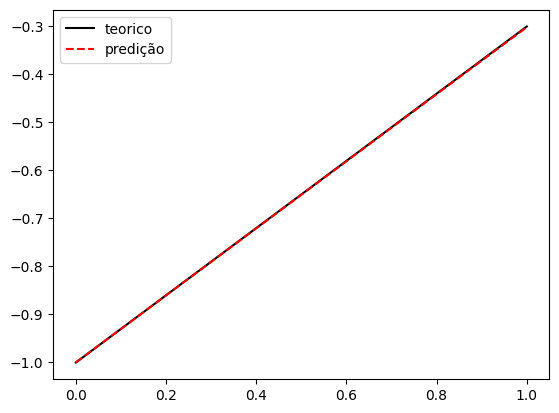

In [13]:
# Aprendendo o valor da constante
model = Regressao_0(10).to("cuda") # rede dos parametros
opt    = tc.optim.Adam(params=model.parameters(),lr=0.01) # rede dos parametros
loss_f  = Loss_parametro(x_train,y_train)

epochs = 5000
for epoch in range(epochs):
    model.train()
    y_preds = model(x_train)
    loss = loss_f(outputs=y_preds)
    opt.zero_grad()
    loss.backward()
    opt.step()

mse_loss = nn.MSELoss()
model.eval()
with tc.inference_mode():
    prediçao = model(x_train)
    loss = mse_loss(y_train[0] + prediçao*x_train,y_train)
    print(f"| Train Loss: {loss} |")
plt.plot(x_train.cpu(),y_train.cpu(),"k-" ,label="teorico")
plt.plot(x_train.cpu(),y_train[0].cpu() + prediçao.cpu().mean()*x_train.cpu(),"r--",label="predição" )
plt.legend()
plt.show()


Aprendendo a função com a edo

| Train Loss: 2.7185380613303778e-09 |


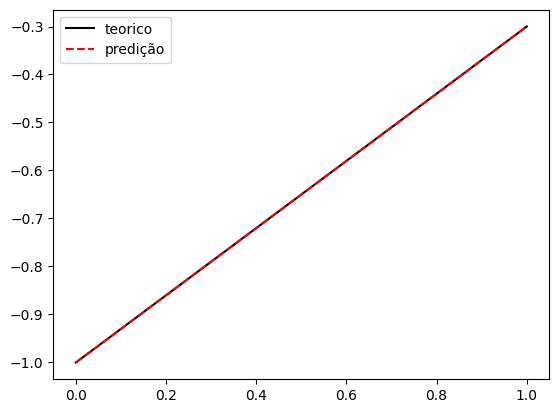

In [14]:
model = Regressao_1(30).to("cuda") # rede da função
opt = tc.optim.Adam(params=model.parameters(),lr=0.01)  # rede da função
loss_f  = Loss_edo(model,-1,0.7,x_train)

epochs = 1000
for epoch in range(epochs):
    x_train.requires_grad_(True)
    model.train()
    y_preds = model(x_train)
    loss = loss_f(y_preds)
    opt.zero_grad()
    loss.backward()
    opt.step()

#rede 1 é a função
loss_fn = nn.MSELoss()
model.eval()
with tc.inference_mode():
    prediçao = model(x_train)
    loss = loss_fn( prediçao,y_train)
    print(f"| Train Loss: {loss} |")

plt.plot(x_train.cpu().detach().numpy(),y_train.cpu().detach().numpy(),"k-" ,label="teorico")
plt.plot(x_train.cpu().detach().numpy(), prediçao.cpu().detach().numpy(),"r--",label="predição" )
plt.legend()
plt.show()

2.850711e-07 parametro: 0.69999766
| Train Loss: 1.834503035591517e-12 |


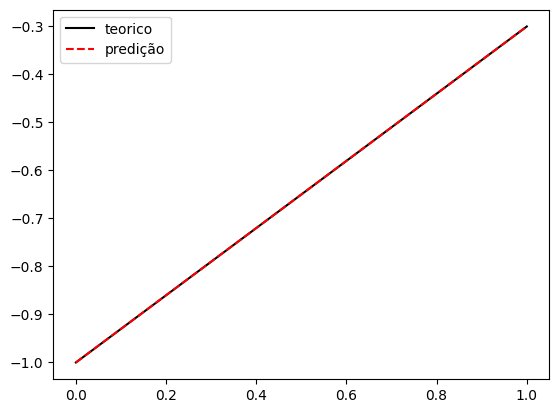

In [30]:
# Vamos aprender o parâmetro da equação com os dados experimentais

# Criando os dados de treino
x_train = tc.linspace(0,1,30,requires_grad=True,device='cuda').reshape(-1,1)
y_train =  eq_movimento(x_0=-1,v_=0.7,t_=x_train)

model = Regressao_1(10).to("cuda") # rede da função
opt = tc.optim.Adam(params=model.parameters(),lr=0.01)  # rede da função
loss_f  = Loss_edo2(x_train,y_train)


for epoch in range(2000):
    x_train.requires_grad_(True)
    model.train()
    y_preds = model(x_train)
    loss = loss_f(y_preds)
    opt.zero_grad()
    loss.backward()
    opt.step()
print(loss.cpu().detach().numpy(),"parametro:",y_preds.mean().cpu().detach().numpy())

loss_fn = nn.MSELoss()
func = y_train[0] + model(x_train).mean()*x_train
loss = loss_fn( func,y_train)
print(f"| Train Loss: {loss} |")

func = func.cpu().detach().numpy()
plt.plot(x_train.cpu().detach().numpy(),y_train.cpu().detach().numpy(),"k-" ,label="teorico")
plt.plot(x_train.cpu().detach().numpy(), func,"r--",label="predição" )
plt.legend()
plt.show()

| Train Loss: 6.714554956488428e-08 | parametro: 0.0001503793
|Erro na  predição : 1.3557125329971313 |


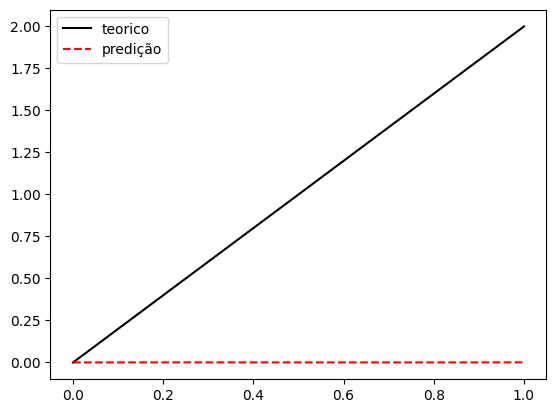

In [66]:
class Regressao_1(nn.Module):
    def __init__(self,neuronio):
        super().__init__()
        self.layer_1 = nn.Linear(1,neuronio)
        self.layer_2 = nn.Linear(neuronio,neuronio)
        self.layer_3 = nn.Linear(neuronio,2)
        self.A_layer = nn.Tanh()

    def forward(self, x):
        x = self.A_layer(self.layer_1(x))
        x = self.A_layer(self.layer_2(x))
        x = self.layer_3(x)
        return x
class Loss_edo3(nn.Module):
    def __init__(self,ic,inputs,data):
        super(Loss_edo3, self).__init__()
        self.t      = inputs
        self.x0     = ic
        self.dy_dt  = tc.autograd.grad(data,inputs, grad_outputs=tc.ones_like(inputs), create_graph=True)[0]
    def forward(self,y_pred):
        solution  =   y_pred[:,1]
        parametro =   y_pred[:,0]

        dydt = tc.autograd.grad(solution, self.t, grad_outputs=tc.ones_like(solution), create_graph=True)[0]

        # Condição inicial x(0).
        loss_ic = (y_pred[0] - self.x0)**2

        # Edo : dx/dt = v.
        loss_edo = tc.mean( (dydt - parametro)**2 )

        # Impor que o input sejá sempre igual.
        loss_const = tc.mean((parametro - parametro.mean()) ** 2)

        # Usando os dado na equação diferencial.
        loss_data = tc.mean( (self.dy_dt - parametro )**2 )
        return loss_ic + loss_edo + loss_const

x_train = tc.linspace(0,1,30,requires_grad=True,device='cuda').reshape(-1,1)
y_train =  eq_movimento(x_0=0,v_=2,t_=x_train)

model = Regressao_1( 30 ).to("cuda") # rede da função
opt = tc.optim.Adam( params = model.parameters(),lr=0.01)  # rede da função
loss_f  = Loss_edo3( ic = 0 ,inputs = x_train, data = y_train)

for epoch in range(2000):
    x_train.requires_grad_(True)
    model.train()
    y_preds = model(x_train)
    loss = loss_f(y_preds).sum()
    opt.zero_grad()
    loss.backward()
    opt.step()

solution  = y_preds[:,0]
parametro = y_preds[:,1]
print(f"| Train Loss: {loss.cpu().detach().numpy()} |","parametro:",parametro.mean().cpu().detach().numpy())

loss_fn = nn.MSELoss()
loss = loss_fn( solution,y_train.reshape(solution.shape))
print(f"|Erro na  predição : {loss.cpu().detach().numpy()} |")


plt.plot(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(),"k-" ,label="teorico")
plt.plot(x_train.cpu().detach().numpy(), solution.cpu().detach().numpy(),"r--",label="predição" )
plt.legend()
plt.show()

# a =Constante

## ML-std

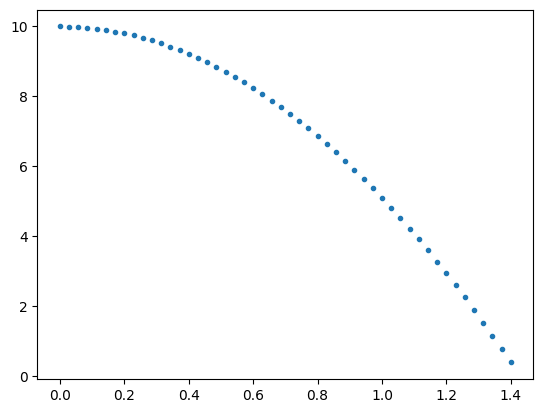

In [ ]:
def eq_movimento(x_0,v_,a_,t_):
    return  x_0 + v_*t_ + a_*t_**2/2

t = np.linspace(0,1.4).reshape((-1, 1))
y = eq_movimento(x_0=10,v_=0,a_=-9.81,t_=t)
plt.plot(t,y,".")
plt.show()

Regressão linear

a:  [[-6.867]]
b:  [11.5696]


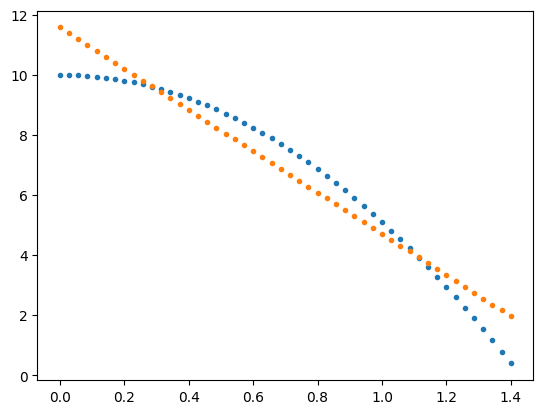

In [ ]:
reg = linear_model.LinearRegression()
reg.fit(t,y)# FITANDO
print("a: ",reg.coef_)
print("b: ",reg.intercept_)

plt.plot(t,y,".")
plt.plot(t,reg.intercept_[0] + reg.coef_[0][0]*t,".")
plt.show()

Decision tree

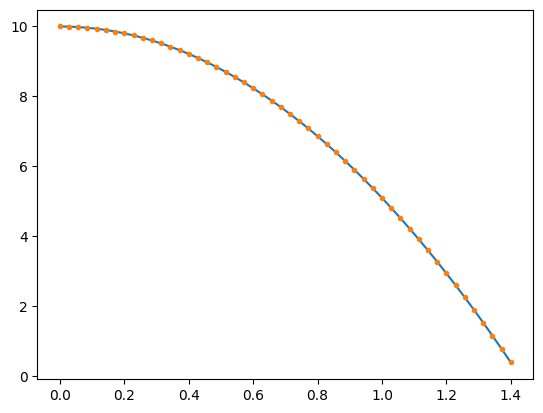

In [ ]:
from sklearn.tree import DecisionTreeRegressor

RT = DecisionTreeRegressor(criterion = "squared_error")
RT.fit(t,y)# FITANDO


predição = RT.predict(t)

plt.plot(t,y,"-")
plt.plot(t,predição,".")

plt.show()

Regressaõ polinomia

Coefficients:  [[ 0.0000000e+00  4.4408921e-16 -4.9050000e+00]]
b:  [10.]


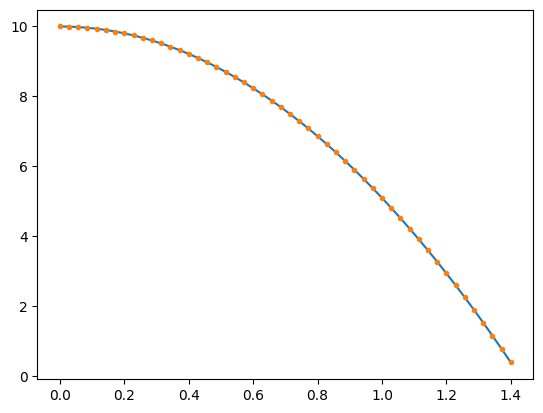

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly = PolynomialFeatures(degree=2)

t_poly = poly.fit_transform(t)

R = linear_model.LinearRegression()
train_y_ = R.fit(t_poly, y)
# The coefficients
print ('Coefficients: ', R.coef_)
print ('b: ',R.intercept_)

predição = R.intercept_[0]+ R.coef_[0][1]*t+ R.coef_[0][2]*t**2
plt.plot(t,y,"-")
plt.plot(t,predição,".")

plt.show()

## ML-Rede neural

Aprendendo a função com os dados

In [ ]:
# Construindo o modelo
class Regressao(nn.Module):
    def __init__(self,neuronio):
        super().__init__()
        self.layer_1 = nn.Linear(1,neuronio)
        self.layer_3 = nn.Linear(neuronio,1)
        self.A_layer = nn.Tanh()

    def forward(self, x):
        x = self.A_layer(self.layer_1(x))
        x = self.A_layer(self.layer_3(x))
        return x
class Regre_Hidden(nn.Module):
    def __init__(self,neuronio):
        super().__init__()
        self.layer_1 = nn.Linear(1,neuronio)
        self.layer_2 = nn.Linear(neuronio,neuronio)
        self.layer_3 = nn.Linear(neuronio,1)
        self.B_layer = nn.Tanh()

    def forward(self, x):
        x = self.B_layer(self.layer_1(x))
        x = self.B_layer(self.layer_2(x))
        x = self.B_layer(self.layer_3(x))
        x = self.layer_3(x)
        return x

class Loss_edo(nn.Module):
    def __init__(self,t,y_true,aceler,velocity=None, rede_neural=None):
        super(Loss_edo,self).__init__()
        self.t_ = t
        self.v_ = velocity
        self.a_ = aceler
        self.y_true_ = y_true
        #self.pinn = rede_neural

    def forward(self,y_pred):
        #y_pred = self.pinn(self.t_)
        dydt = tc.autograd.grad(y_pred, self.t_, grad_outputs=tc.ones_like(y_pred), create_graph=True)[0]
        d2ydt2 = tc.autograd.grad(dydt, self.t_, grad_outputs=tc.ones_like(dydt), create_graph=True)[0]
        # The residual of the second-order ODE
        f = d2ydt2   - self.a_ #- dydt*self.v_
        f2 = dydt - self.a_
        return (tc.sum(f**2)+ tc.sum(f2**2) + (y_pred[0] -self.y_true_[0] )**2)/len(self.t_*3)

class CustomLoss(nn.Module):
    def __init__(self,x_0,v_0):
        super().__init__()
        self.x0 = x_0
        self.v0 = v_0

    def forward(self, outputs, y_,t_):
        # talvez adicionar a derivada
        # y  =  x_0 + v_*t_ + a_*t_**2/2
        return 1*tc.mean((y_ - self.x0 -self.v0*t_ - outputs[0,1]*t_**2/2)** 2) # +1*tc.mean( (y_- outputs[:,0])**2 )


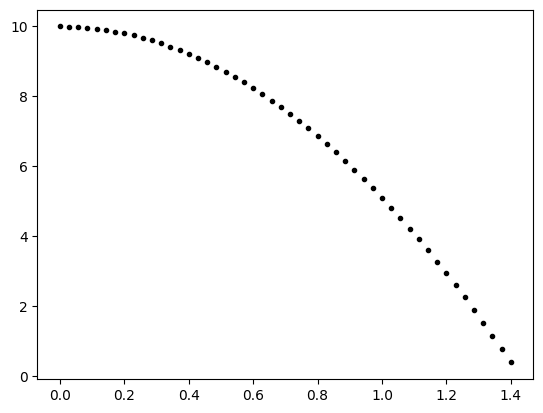

In [ ]:
def eq_movimento(x_0,v_,a_,t_):
    return  x_0 + v_*t_ + a_*t_**2/2


# Criando os dados de treino
x_train = tc.linspace(0,1.4,50,requires_grad=True).reshape(50,1)
y_train =  eq_movimento(x_0=10,v_=0,a_=-9.81,t_=x_train)

# Visualizando os dados de treino

plt.plot(x_train.detach().numpy(),y_train.detach().numpy(),"k." )
plt.show()

In [ ]:

# model = Regre_Hidden(neuronio=5)
# loss_fn = nn.MSELoss()
# optimizer = tc.optim.Adam(params=model.parameters(),lr=0.01)

# epochs = 10000
# for epoch in range(epochs):
#     model.train()
#     y_preds = model(x_train)
#     loss = loss_fn(y_preds, y_train)
#     optimizer.zero_grad()
#     loss.backward(retain_graph=True)
#     optimizer.step()

# model.eval()
# with tc.inference_mode():
#     y_preds_test = model(x_train)
#     loss = loss_fn(y_preds_test,y_train)
#     print(f"| Train Loss: {loss} | ")

# plt.plot(x_train.detach().numpy(),y_train.detach().numpy(),"-" )
# plt.plot(x_train.detach().numpy(),y_preds_test.detach().numpy(),"k." )
# plt.show()

aprendendo o parametro da equação(Aceleração)

In [ ]:
# model = Regre_Hidden(neuronio=2)
# loss_fn = CustomLoss(x_0=10,v_0=0)
# optimizer = tc.optim.Adam(params=model.parameters(),lr=0.01)

# epochs = 5000
# for epoch in range(epochs):
#     model.train()

#     y_preds = model(x_train)
#     loss = loss_fn(y_preds, y_train,x_train)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

# model.eval()

# with tc.inference_mode():
#     y_preds_test = model(x_train)
#     loss = loss_fn(y_preds_test,y_train,x_train)

#     print(f"| Train Loss: {loss} | ")

# plt.plot(x_train,y_train,"-", label="teorico")
# plt.plot(x_train,10 + y_preds_test[0,1]*x_train**2/2,"k--", label=f"a:{tc.round(y_preds_test[0,1],decimals=2)}" )
# #plt.plot(x_train,y_preds_test[:,0],"r--", label="funçãoda rede" )
# plt.legend()
# plt.show()

In [ ]:
model = Regre_Hidden(neuronio=3)
y_preds = model(x_train)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (50x1 and 3x1)

In [ ]:
model = Regre_Hidden(neuronio=2)
loss_fn = Loss_edo(x_train,y_train,aceler=1)

optimizer = tc.optim.Adam(params=model.parameters(),lr=0.01)

epochs = 5000
for epoch in range(epochs):
    model.train()

    y_preds = model(x_train)
    loss = loss_fn(y_preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

y_pred = pinn(x_train)
plt.plot(x_train.detach().numpy(),y_train.detach().numpy(),"-", label="teorico")
plt.plot(x_train.detach().numpy(),y_pred.detach().numpy(),"--", label="simulado")
plt.legend()
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (50x1 and 2x1)